# **Versión 5: Transfer Learning, Fine Tunning y Callbacks**
**Gabriela Chimali Nava Ramírez | A01710530**

01/12/2025

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import json
import os

In [3]:
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
print("GPU Details:", tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available: 1
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
strategy = tf.distribute.MirroredStrategy()
print(f"Number of GPUs being used: {strategy.num_replicas_in_sync}")

Number of GPUs being used: 1


## **1. Carga de datos**

In [5]:
train_path = r"/kaggle/input/cards-image-datasetclassification/train"
test_path = r"/kaggle/input/cards-image-datasetclassification/test"
validation_path = r"/kaggle/input/cards-image-datasetclassification/valid"

In [6]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Data Augmentation sólo para TRAIN
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.05,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    class_mode ="categorical"
)

val_generator = val_datagen.flow_from_directory(
    validation_path,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator = val_datagen.flow_from_directory(
    test_path,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


## **2. Construcción del Modelo**

In [7]:
class_names = sorted(os.listdir(train_path))
print(f"Nombres de las clases encontradas: {class_names}")
print(f"Número total de clases: {len(class_names)}")

Nombres de las clases encontradas: ['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']
Número

### **2.1. Declaración del modelo**

In [8]:
NUM_CLASSES = 53
IMG_SIZE = (224,224)

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Descongelar modelo base
base_model.trainable = True

# Congelar todas las capas EXCEPTO las últimas
for layer in base_model.layers[:-30]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 53)                  │          67,893 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,325,877 (8.87 MB)

 Trainable params: 1,594,293 (6.08 MB)

 Non-trainable params: 731,584 (2.79 MB)

### **2.2. Compilación del modelo**

In [10]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(
    filepath='classifier_model.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
    verbose = 1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose = 1
)

my_callbacks = [checkpoint, early_stop, reduce_lr]

## **3. Entrenamiento**

In [11]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[my_callbacks]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.0280 - loss: 4.3726
Epoch 1: val_accuracy improved from -inf to 0.07547, saving model to classifier_model.keras
239/239 ━━━━━━━━━━━━━━━━━━━━ 174s 639ms/step - accuracy: 0.0281 - loss: 4.3719 - val_accuracy: 0.0755 - val_loss: 3.8847 - learning_rate: 1.0000e-05
Epoch 2/100
238/239 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.0869 - loss: 3.7294
Epoch 2: val_accuracy improved from 0.07547 to 0.12830, saving model to classifier_model.keras
239/239 ━━━━━━━━━━━━━━━━━━━━ 99s 402ms/step - accuracy: 0.0871 - loss: 3.7283 - val_accuracy: 0.1283 - val_loss: 3.3200 - learning_rate: 1.0000e-05
Epoch 3/100
238/239 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.1546 - loss: 3.3084
Epoch 3: val_accuracy improved from 0.12830 to 0.19245, saving model to classifier_model.keras
239/239 ━━━━━━━━━━━━━━━━━━━━ 101s 412ms/step - accuracy: 0.1548 - loss: 3.3077 - val_accuracy: 0.1925 - val_loss: 2.8345 - learning_rate: 1.0000e-05
Epoch 4/100
238/2

## **4. Métricas del entrenamiento**

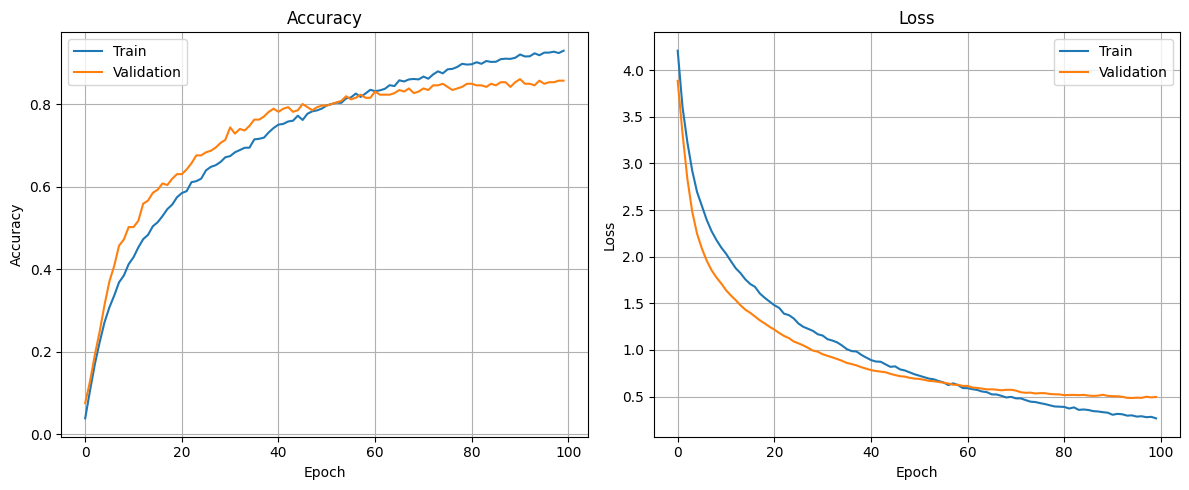

In [12]:
hist_df = pd.DataFrame(history.history)

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
hist_df[['accuracy', 'val_accuracy']].plot(ax=plt.gca())
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
hist_df[['loss', 'val_loss']].plot(ax=plt.gca())
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.grid(True)

plt.tight_layout()
plt.show()

## **5. Evaluación del modelo con TEST**

2/9 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9375 - loss: 0.2545

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.8444 - loss: 0.5456

Test Loss: 0.6452
Test Accuracy: 0.8113
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 366ms/step


<Figure size 2200x1000 with 0 Axes>

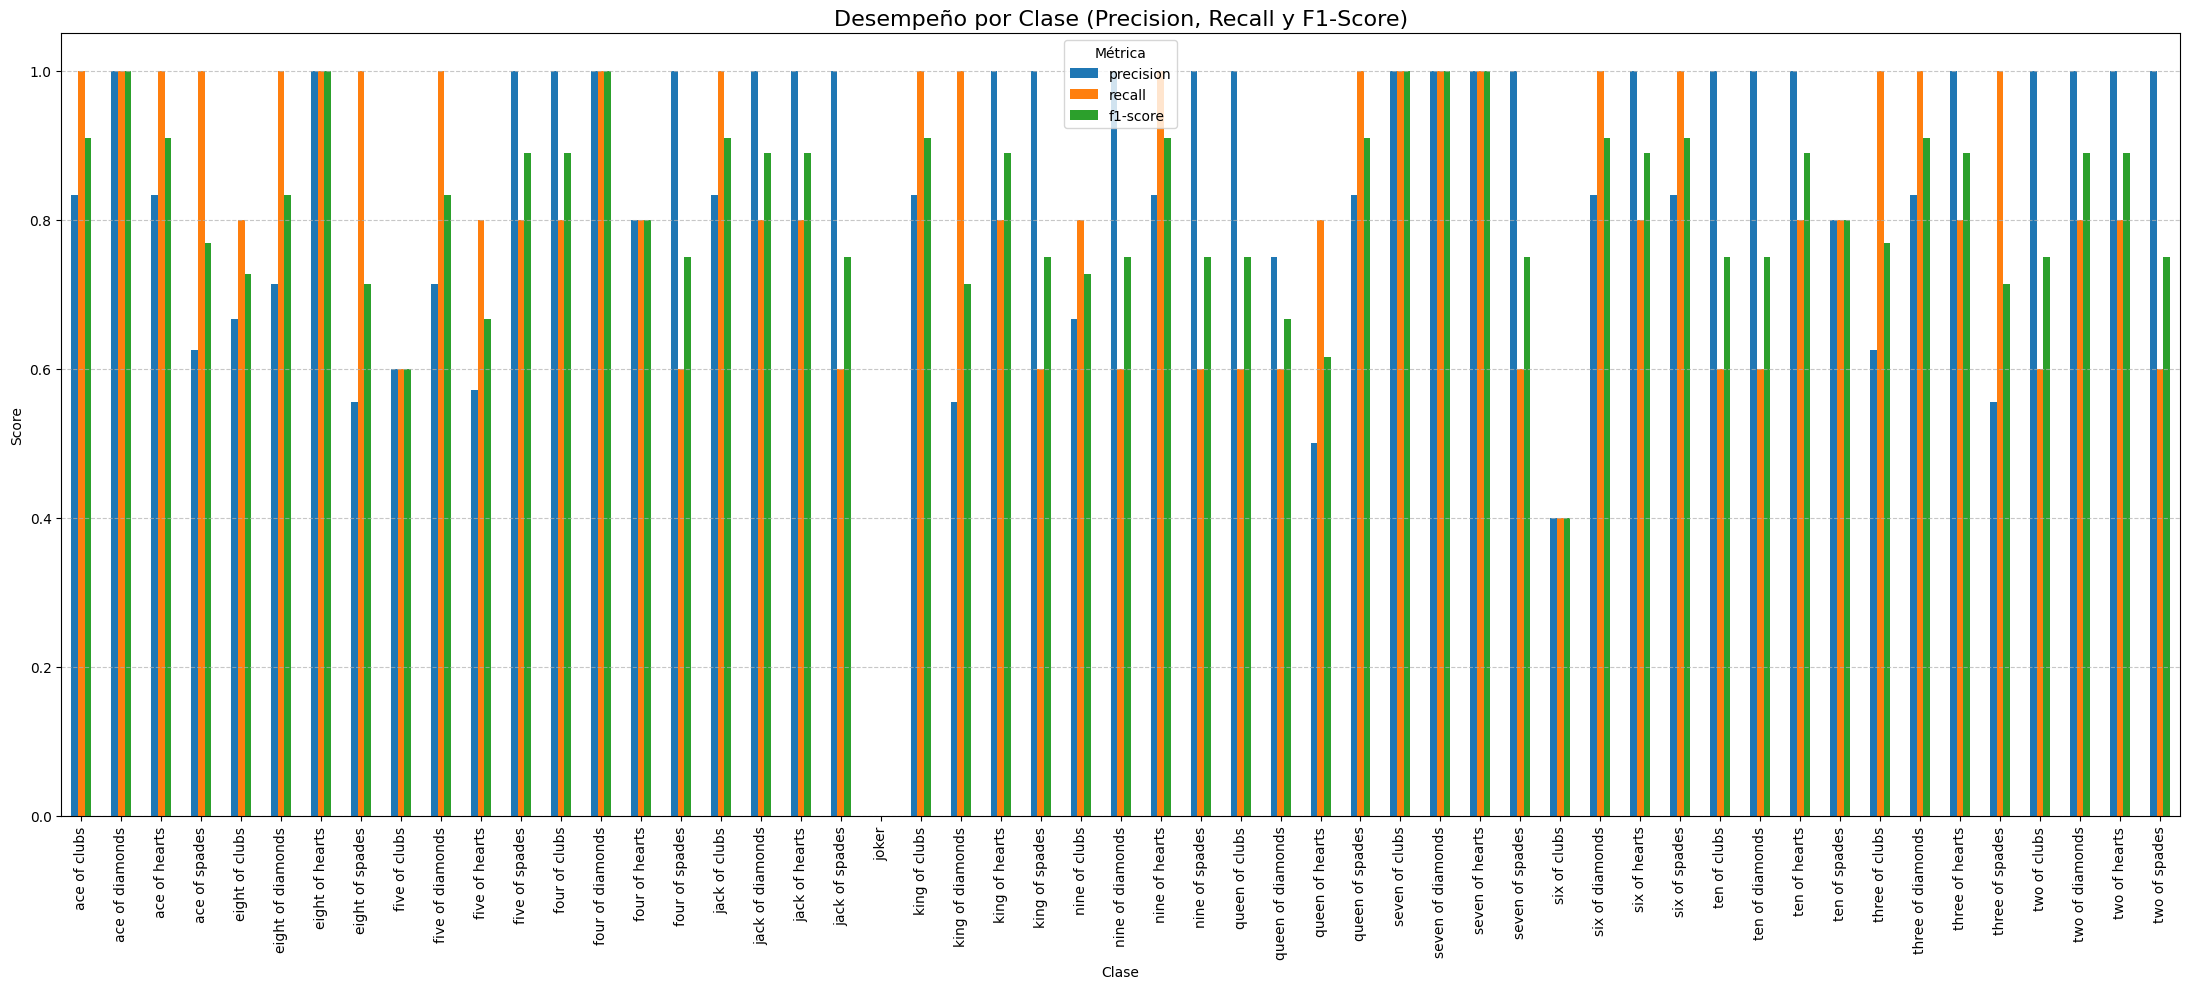

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

# Evaluación
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predicciones
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes

# Reporte
report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(index=['accuracy', 'macro avg', 'weighted avg'])

# Reorganizar
metrics = ['precision', 'recall', 'f1-score']
report_df = report_df[metrics]

# Gráfica de barras agrupadas
plt.figure(figsize=(22, 10))
report_df.plot(kind='bar', figsize=(22, 10))
plt.title("Desempeño por Clase (Precision, Recall y F1-Score)", fontsize=16)
plt.xlabel("Clase")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=90)
plt.legend(title="Métrica")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

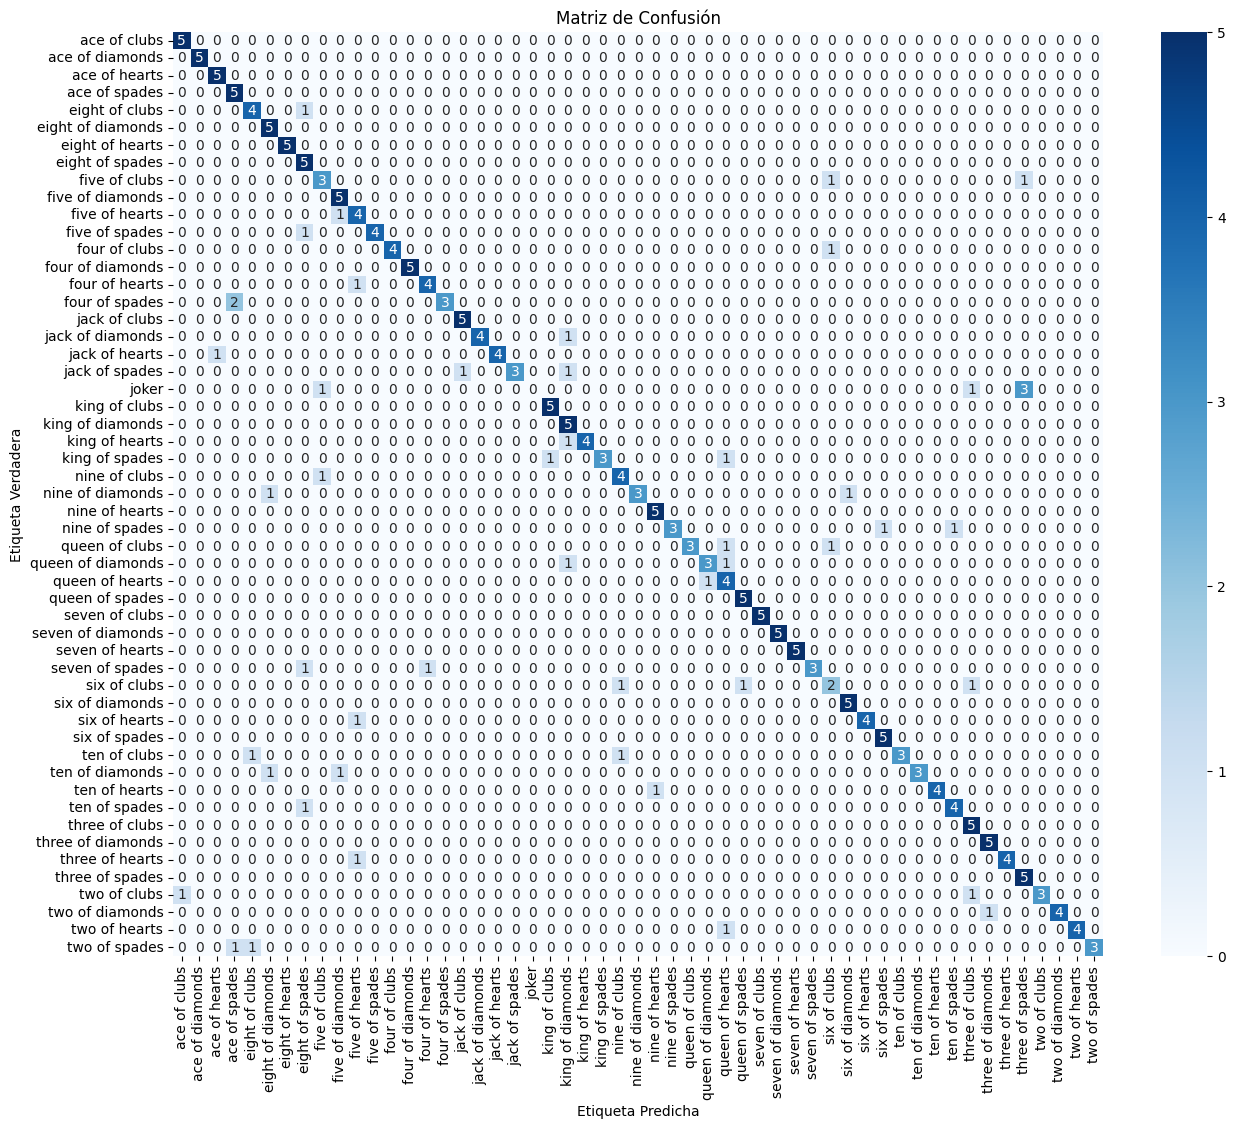

In [14]:
# Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión")
plt.ylabel("Etiqueta Verdadera")
plt.xlabel("Etiqueta Predicha")
plt.show()

In [ ]:
# Crear dataframe con las etiquetas verdaderas y predichas
df_results = pd.DataFrame({
    'true_label': [class_names[i] for i in y_true],
    'pred_label': [class_names[i] for i in y_pred]
})

# Funciones para extraer valor y palo
def get_value(card_name):
    return card_name.split(' ')[0]

def get_suit(card_name):
    return card_name.split(' ')[-1]

# Funciones para crear las columnas
df_results['true_suit'] = df_results['true_label'].apply(get_suit)
df_results['pred_suit'] = df_results['pred_label'].apply(get_suit)
df_results['true_value'] = df_results['true_label'].apply(get_value)
df_results['pred_value'] = df_results['pred_label'].apply(get_value)

all_suits = ['hearts', 'diamonds', 'clubs', 'spades', 'joker']

# Crear la matriz
suit_conf = pd.crosstab(df_results['true_suit'], df_results['pred_suit'])

# Asegurar que el Joker aparezca
suit_conf = suit_conf.reindex(index=all_suits, columns=all_suits, fill_value=0)

# Matriz por palo
plt.figure(figsize=(6,5))
sns.heatmap(suit_conf, annot=True, cmap="Blues", fmt="d")
plt.title("Matriz de Confusión por Palo")
plt.xlabel("Palo Predicho")
plt.ylabel("Palo Verdadero")
plt.show()

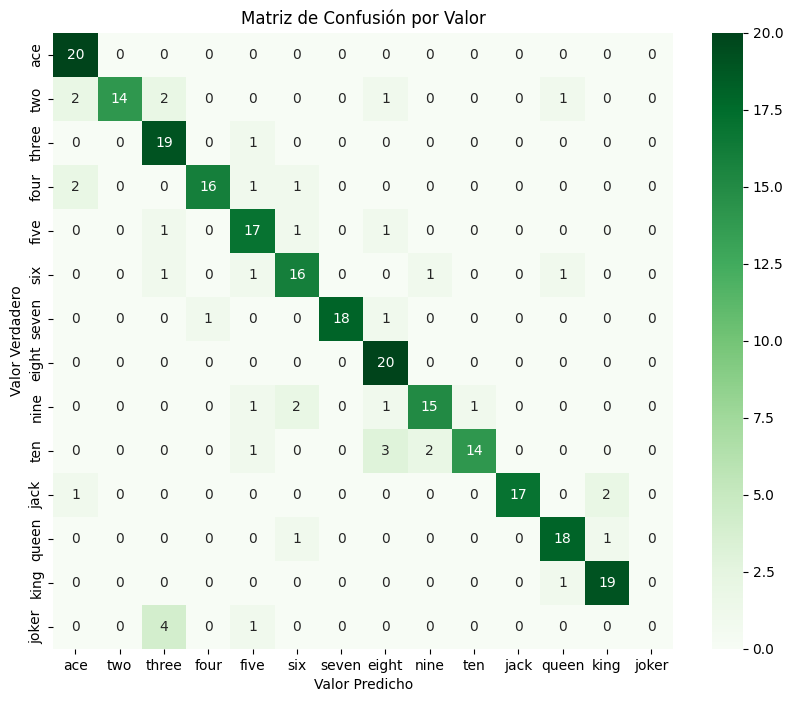

In [16]:
# Matriz por valor
value_conf = pd.crosstab(df_results['true_value'], df_results['pred_value'])
value_conf = value_conf.reindex(index=card_value_order, columns=card_value_order).fillna(0).astype(int)
plt.figure(figsize=(10,8))
sns.heatmap(value_conf, annot=True, cmap="Greens", fmt="d")
plt.title("Matriz de Confusión por Valor")
plt.xlabel("Valor Predicho")
plt.ylabel("Valor Verdadero")
plt.show()

## **6. Guardado del modelo**

In [18]:
PROJECT_PATH = "/kaggle/working/"

model.save(PROJECT_PATH + "classifier_model.keras")

with open(PROJECT_PATH + 'history.json', 'w') as f:
    json.dump(history.history, f)